# **Writing my own movie descriptions**

Getting the Text data from descriptions of movies given in this dataset, I am going to predict next sentences to them. 


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
netflix = pd.read_csv('../input/netflix-shows/netflix_titles.csv')
netflix.head()

In [ ]:
#Importing relevant libraries
import os
import nltk
from nltk.util import ngrams
#from nltk.lm import MLE
from nltk import word_tokenize
# we need to download a special component that is used by the tokenizer below 
nltk.download('punkt')
import tensorflow as tf
import numpy as np
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import numpy
import pandas as pd
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import nltk
nltk.download('stopwords')
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

#Employing Early stopping as a means of Validation
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#Deciding on number of epochs
#Number of Epochs is how many time the entire dataset has to pass through the network
num_epochs = 100
#Using pre-trained embedding
#embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
#embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], #output_shape=[128], 
                           dtype=tf.string, trainable=False)

In [ ]:
all_text =[]
counter =0
for text in netflix.description:
  all_text.append(text)
  counter+=1

#Total rows traverse in every dataframe - negative and positive   
print("Total number of movie descriptions added to our corpus:",counter)
#Creating strings of all descriptions 
all_text = " ".join(all_text)

#Reviweing sample text
print("Text Sample : ",all_text[:500])


Preparing my model on all description texts -

* Preparing vocabulary with indices
* Setting up dataset
* Setting up input and output data for training

In [ ]:
#Setting up vocabularies and datasets
textall = all_text

# extract an ordered vocabulary - this will be letters, some numbers etc. 
vocaball = sorted(set(textall))

# Create mappings between vocab and numeric indices
char2idxall = {u:i for i, u in enumerate(vocaball)}
idx2charall = np.array(vocaball)

# Map all the training text over to a numeric representation
text_as_intall = np.array([char2idxall[c] for c in textall])

# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epochall = len(textall)//(seq_length+1)

# Create training examples / targets
char_datasetall = tf.data.Dataset.from_tensor_slices(text_as_intall)
sequencesall = char_datasetall.batch(seq_length+1, drop_remainder=True)

# This function would create input and output training data for our model on the fly
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text


# Mapping the above function to entire dataset 
datasetall = sequencesall.map(split_input_target)

#Setting up hyperparameters
embedding_dim = 256
BATCH_SIZE = 64
BUFFER_SIZE = 10000
rnn_units = 2048

#Tensorflow wil use this buffer size and batch size to work with the problem data
datasetall = datasetall.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)



## Designing the Neural Languagage Model

In [ ]:
#To generate some new text we first define a function that can be used to generate this text
#The function takes the trained neural language model as input and a chunk of text that is used to 'prime' or seed the generator
def generate_text(model, start_string, chr2,idx2):

    char2idx = chr2
    idx2char = idx2

    # Number of characters to generate
    num_generate = 100

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    text_ids_gen = []
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_ids_gen.append(predicted_id)
        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))


In [ ]:
#Desiging our model - ALL Text
mall = tf.keras.Sequential()
#An embedding layer to capture meaning of words in a real valued space.
mall.add(tf.keras.layers.Embedding(len(vocaball), embedding_dim,
                          batch_input_shape=[BATCH_SIZE, None]))
#Recurrent layer - Long Short Term Memory
mall.add(tf.keras.layers.LSTM(rnn_units,
                    return_sequences=True,
                    stateful=True,
                    recurrent_initializer='glorot_uniform'))
#Final output layer with one neuron per vovab entry
mall.add(tf.keras.layers.Dense(len(vocaball)))
#Displaying the model parameters 
mall.summary()
#Cross entropy as it is a multiple class classification problem. Using ADAM optimizer for it best performs in case of classification
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
mall.compile(optimizer='adam', loss=loss)


In [ ]:
#To save checkpoints or models
my_temp_folder = "../kaggle/working/"

In [ ]:
# Directory where the checkpoints will be saved for Negative, Positive and ALL
checkpoint_dirall = my_temp_folder+'training_checkpoints_lstmall'
import shutil
try:
    shutil.rmtree(checkpoint_dirall)
except:
    print("directory not used yet.")

In [ ]:
# Setting up temporary checkpoints for Negative, Positive and ALL
# Creating callback object that can be supplied to the keras fit function. 
# Name of the checkpoint files
checkpoint_prefixall = os.path.join(checkpoint_dirall, "ckpt_")

cball=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefixall,
    monitor='loss',
    save_weights_only=True,
    save_best_only=True)


In [ ]:
#All Text
historyall = mall.fit(datasetall, epochs=50,callbacks=[cball],verbose=1)
print("training complete for ALL Descriptions.")


So , I have tried epoch as small as 20 and as high as 100 here. The training loss starts to increase after 45 epochs, thus I have chosen the number of epochs as 50 which is around 45 only.

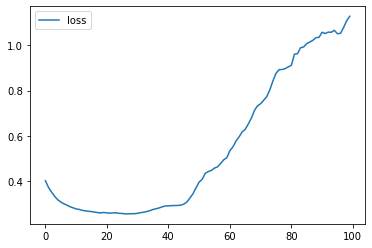

In [ ]:

historyall.history.values() 
historyall.history.keys() 


import pandas as pd
lossdfall=pd.DataFrame(historyall.history)
lossdfall.plot()

Since, purpose of me writing up this kernel is to help a reader understand how can a neural network be used to generate engligh language text. I am not going to put more time and effort in reducing the loss further. 

In [ ]:

modelall = tf.keras.Sequential()
modelall.add(tf.keras.layers.Embedding(len(vocaball), embedding_dim,
                          batch_input_shape=[1, None]))
modelall.add(tf.keras.layers.LSTM(rnn_units,
                    return_sequences=True,
                    stateful=True,
                    recurrent_initializer='glorot_uniform'))
modelall.add(tf.keras.layers.Dense(len(vocaball)))
#Reloading and changing batch size to 1
modelall.load_weights(tf.train.latest_checkpoint(checkpoint_dirall))
modelall.build(tf.TensorShape([1, None]))


Lets look at how our **Text Generator** is performing by seeding the moddel with first movie description in the dataset.

In [ ]:
netflix.description[0]

In [ ]:
#Generating Text for ALL movie descriptions with seed words as the initial movie descriptions 
#Lets generate five sentences, so that i can calculate copus BLEU score

all_text = generate_text(modelall, start_string=netflix.description[0],chr2=char2idxall, idx2=idx2charall)
print(all_text)


Here you can see that the model is able to formulate proper words most of the time, and semantically the sentence generated is aalso correct. To make the sentences more meaningful, we can train the model further by increasing the number of epochs. Reeader can try this out in his own time.

Here, I am displaying two more samples for your undertanding -


In [ ]:
print(netflix.description[1])

In [ ]:
#Generating Text for ALL movie descriptions with seed words as the initial movie descriptions 
#Lets generate five sentences, so that i can calculate copus BLEU score

all_text = generate_text(modelall, start_string=netflix.description[1],chr2=char2idxall, idx2=idx2charall)
print(all_text)


One more example and I will end the kernel here -

In [ ]:
print(netflix.description[2])

In [ ]:
#Generating Text for ALL movie descriptions with seed words as the initial movie descriptions 
#Lets generate five sentences, so that i can calculate copus BLEU score

all_text = generate_text(modelall, start_string=netflix.description[2],chr2=char2idxall, idx2=idx2charall)
print(all_text)
